In [8]:
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
import wget
import numpy as np
import torch as ch
import torchvision

from trak import TRAKer

# Initialize model and dataloaders

In [12]:
try:
    from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
    from ffcv.loader import Loader, OrderOption
    from ffcv.pipeline.operation import Operation
    from ffcv.transforms import RandomHorizontalFlip, Cutout, \
        RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
    from ffcv.transforms.common import Squeeze
except:
    print('No ffcv installed')

BETONS = {
        'train': "https://www.dropbox.com/s/zn7jsp2rl09e0fh/train.beton?dl=1",
        'val': "https://www.dropbox.com/s/4p73milxxafv4cm/val.beton?dl=1",
}

STATS = {
        'mean': [125.307, 122.961, 113.8575],
        'std': [51.5865, 50.847, 51.255]
}

def get_dataloader(batch_size=256,
                   num_workers=8,
                   split='train',  # split \in [train, val]
                   aug_seed=0,
                   should_augment=True,
                   indices=None):
        label_pipeline: List[Operation] = [IntDecoder(),
                                           ToTensor(),
                                           ToDevice(ch.device('cuda:0')),
                                           Squeeze()]
        image_pipeline: List[Operation] = [SimpleRGBImageDecoder()]

        if should_augment:
                image_pipeline.extend([
                        RandomHorizontalFlip(),
                        RandomTranslate(padding=2, fill=tuple(map(int, STATS['mean']))),
                        Cutout(4, tuple(map(int, STATS['std']))),
                ])

        image_pipeline.extend([
            ToTensor(),
            ToDevice(ch.device('cuda:0'), non_blocking=True),
            ToTorchImage(),
            Convert(ch.float32),
            torchvision.transforms.Normalize(STATS['mean'], STATS['std']),
        ])
        
        beton_url = BETONS[split]
        beton_path = f'./{split}.beton'
        wget.download(beton_url, out=str(beton_path), bar=None)
        
        return Loader(beton_path,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      order=OrderOption.SEQUENTIAL,
                      drop_last=False,
                      seed=aug_seed,
                      indices=indices,
                      pipelines={'image': image_pipeline, 'label': label_pipeline})

# Resnet9
class Mul(ch.nn.Module):
    def __init__(self, weight):
        super(Mul, self).__init__()
        self.weight = weight
    def forward(self, x): return x * self.weight


class Flatten(ch.nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)


class Residual(ch.nn.Module):
    def __init__(self, module):
        super(Residual, self).__init__()
        self.module = module
    def forward(self, x): return x + self.module(x)


def construct_rn9(num_classes=2):
    def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1, groups=1):
        return ch.nn.Sequential(
                ch.nn.Conv2d(channels_in, channels_out, kernel_size=kernel_size,
                            stride=stride, padding=padding, groups=groups, bias=False),
                ch.nn.BatchNorm2d(channels_out),
                ch.nn.ReLU(inplace=True)
        )
    model = ch.nn.Sequential(
        conv_bn(3, 64, kernel_size=3, stride=1, padding=1),
        conv_bn(64, 128, kernel_size=5, stride=2, padding=2),
        Residual(ch.nn.Sequential(conv_bn(128, 128), conv_bn(128, 128))),
        conv_bn(128, 256, kernel_size=3, stride=1, padding=1),
        ch.nn.MaxPool2d(2),
        Residual(ch.nn.Sequential(conv_bn(256, 256), conv_bn(256, 256))),
        conv_bn(256, 128, kernel_size=3, stride=1, padding=0),
        ch.nn.AdaptiveMaxPool2d((1, 1)),
        Flatten(),
        ch.nn.Linear(128, num_classes, bias=False),
        Mul(0.2)
    )
    return model

In [13]:
model = construct_rn9().to(memory_format=ch.channels_last).cuda()
model = model.eval()

In [14]:
batch_size = 50
loader_train = get_dataloader(batch_size=batch_size, split='train')
loader_val = get_dataloader(batch_size=batch_size, split='val')

# Train models

In [ ]:
# TODO

# Create a list of trained model checkpoints

In [19]:
# TODO: put on dropbox
ckpt_files = list(Path('/mnt/cfs/projects/better_tracin/checkpoints/resnet9_cifar2/50pct/100models_1epochs').rglob('*/*.pt'))
ckpts = [ch.load(ckpt, map_location='cpu') for ckpt in ckpt_files]

# Calculate ground-truth model outputs (predictions)

In [15]:
# TODO

In [16]:
# TODO: put on dropbox
EVAL_DIR = Path('/mnt/cfs/home/spark/store/kernel/cifar2/50pct_new_augs_10x_per_mask')

indices = np.where(np.load(EVAL_DIR / '_completed.npy'))[0]
comp_indices = []

for i in tqdm(range(0, 99480, 10)):
    if all(j in indices for j in range(i,i+10)):
        comp_indices.extend(list(range(i,i+10)))

masks = {}
margins = {}

masks['cifar2-avg'] = np.load(EVAL_DIR / 'mask.npy')[comp_indices[::10]]
margins['cifar2-avg'] = np.load(EVAL_DIR / 'val_margins.npy')[comp_indices]
margins['cifar2-avg'] = margins['cifar2-avg'].reshape(len(margins['cifar2-avg']) // 10,10,2000).mean(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9948/9948 [00:02<00:00, 3595.22it/s]


# Calcuate TRAK scores for the checkpoints

In [27]:
device = 'cuda:0'
traker = TRAKer(model=model,
              task='image_classification',
              train_set_size=10_000,
              proj_dim=4096,
              save_dir='./trak_results_cifar2_100models_all',
              device=device)

Existing IDs in /mnt/xfs/home/krisgrg/projects/trak/examples/trak_results_cifar2_100models_all: [3, 2, 4, 0, 5, 1]


In [28]:
for model_id, ckpt in enumerate(tqdm(ckpts[:5])):
    traker.load_checkpoint(ckpt, model_id=model_id)
    for batch in loader_train:
        traker.featurize(batch=batch, num_samples=batch_size)

traker.finalize_features()

Finalizing features for all model IDs..: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.39s/it]


In [29]:
for model_id, ckpt in enumerate(tqdm(ckpts[:5])):
    traker.start_scoring_checkpoint(ckpt, model_id=model_id, num_targets = len(loader_val.indices))
    for batch in loader_val:
        traker.score(batch=batch, num_samples=batch_size)

scores = traker.finalize_scores()

Finalizing scores for all model IDs..: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.32it/s]


Saving scores in /mnt/xfs/home/krisgrg/projects/trak/examples/trak_results_cifar2_100models_all/scores/scores_0fcabbd0-ad58-42d5-8ca2-865d6ecc84f7.npy


# Evaluate the correlation between model outputs and their TRAK estimates

In [30]:
def eval_correlations(infls, val_inds, masks, margins):
    preds = masks @ infls
    rs = []
    ps = []
    for ind, j in tqdm(enumerate(val_inds)):
        r, p = spearmanr(preds[:, ind], margins[:, j])
        rs.append(r)
        ps.append(p)
    return np.array(rs), np.array(ps)

2000it [00:04, 471.33it/s]


Correlation: 0.017304054241303442 (avg p value 0.22772424079004397)


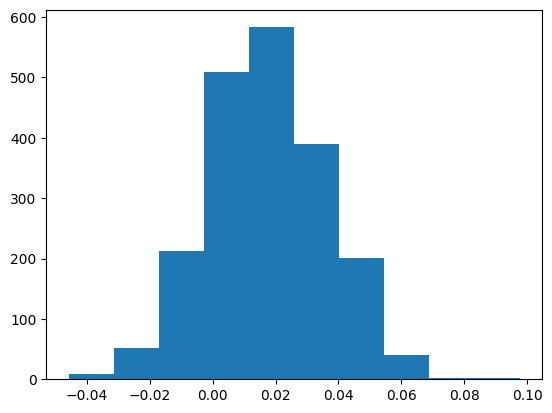

In [32]:
infls = scores.cpu().numpy()
val_inds = np.arange(2000)
rs, ps = eval_correlations(infls, val_inds, masks['cifar2-avg'], margins['cifar2-avg'])

print(f'Correlation: {rs.mean()} (avg p value {ps.mean()})')
plt.hist(rs)
plt.savefig('rs.png')